In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.stats import pearsonr
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('zacs_features1.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

,RegionName,ZORI,Year,renter_occupied_housing_units_paying_cash_median_gross_rent,owner_occupied_housing_units_median_value,married_households,housing_units_renter_occupied,nonfamily_households,vacant_housing_units_for_rent,income_10000_29999,...,occupation_natural_resources_construction_maintenance,median_age,total_pop,white_pop,black_pop,hispanic_pop,walked_to_work,commuters_by_public_transportation,commute_10_14_mins,gini_index
0,10025,2883,2014,1438,976900,13337,33778,24576,991,12032,...,1269,39.3,97373,54332,9768,21654,6270,32889,2530,0.5699
1,10025,2895,2014,1438,976900,13337,33778,24576,991,12032,...,1269,39.3,97373,54332,9768,21654,6270,32889,2530,0.5699
2,10025,2907,2014,1438,976900,13337,33778,24576,991,12032,...,1269,39.3,97373,54332,9768,21654,6270,32889,2530,0.5699
3,10025,2920,2014,1438,976900,13337,33778,24576,991,12032,...,1269,39.3,97373,54332,9768,21654,6270,32889,2530,0.5699
4,10025,2933,2014,1438,976900,13337,33778,24576,991,12032,...,1269,39.3,97373,54332,9768,21654,6270,32889,2530,0.5699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155719,60602,2260,2018,3055,454234,420,377,182,1,66,...,0,30.6,1244,788,47,81,362,233,79,0.4940
155720,60602,2266,2018,3055,454234,420,377,182,1,66,...,0,30.6,1244,788,47,81,362,233,79,0.4940
155721,60602,2273,2018,3055,454234,420,377,182,1,66,...,0,30.6,1244,788,47,81,362,233,79,0.4940
155722,60602,2279,2018,3055,454234,420,377,182,1,66,...,0,30.6,1244,788,47,81,362,233,79,0.4940


In [4]:
df.isna().sum()

RegionName                                                     0
ZORI                                                           0
Year                                                           0
renter_occupied_housing_units_paying_cash_median_gross_rent    0
owner_occupied_housing_units_median_value                      0
married_households                                             0
housing_units_renter_occupied                                  0
nonfamily_households                                           0
vacant_housing_units_for_rent                                  0
income_10000_29999                                             0
income_75000_99999                                             0
median_income                                                  0
income_100000_199999                                           0
income_200000_or_more                                          0
million_dollar_housing_units                                   0
dwellings_50_or_more_unit

In [5]:
region = df.RegionName.value_counts().keys()
region

Int64Index([ 2111, 30318, 30062, 75204, 10027, 95822, 28269, 77450, 85382,
            75019,
            ...
            76119, 90067, 95242, 94015, 11550, 55391,  8033, 95111, 32169,
            95130],
           dtype='int64', length=2720)

In [7]:
for reg in region:
    df2 = df[df.RegionName==reg].copy()
    # df2 = df
    start_yr = df2.iloc[0,2]
    
    df2.drop(['RegionName','Year'],axis=1,inplace=True)
    valid_clm = [] #VAR dosent take constanct value
    for c in df2.columns:
        if len(df2[c].value_counts())>1:
            valid_clm.append(c)

    df2 = df2[valid_clm]
    d = datetime.strptime(str(start_yr),'%Y')
    date_index = [d+timedelta(days=30*i) for i in range(len(df2.index))]
    df2.index = pd.DatetimeIndex(date_index)
    df3 = df2[['gini_index','dwellings_50_or_more_units','ZORI','income_10000_29999','occupation_natural_resources_construction_maintenance']]
    model = VAR(endog=df3)
    result= model.fit(maxlags=1)
# #     model.predict(3*12)
#     print(result.summary())
    pred = result.forecast(result.y,steps=3*12)    
    d = df3.index[-1]
    prd = pd.DataFrame()
    time = [d+timedelta(days=30*i) for i in range(3*12)]
    prd['ZORI'] = pred[:,2]
    prd.index = time
    prd.to_csv('prediction.csv')
    print("prediction.csv generated\n")
    lr = LinearRegression()
    lr.fit(df2.drop(['ZORI'],axis=1),df2.ZORI)
    print("LinearRegression R2 score : ",lr.score(df2.drop(['ZORI'],axis=1),df2.ZORI))
    break

prediction.csv generated

LinearRegression R2 score :  0.9090161775346246


/Users/jaymehdi/venv_e33a/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  warnings.warn('No frequency information was'
/Users/jaymehdi/venv_e33a/lib/python3.9/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


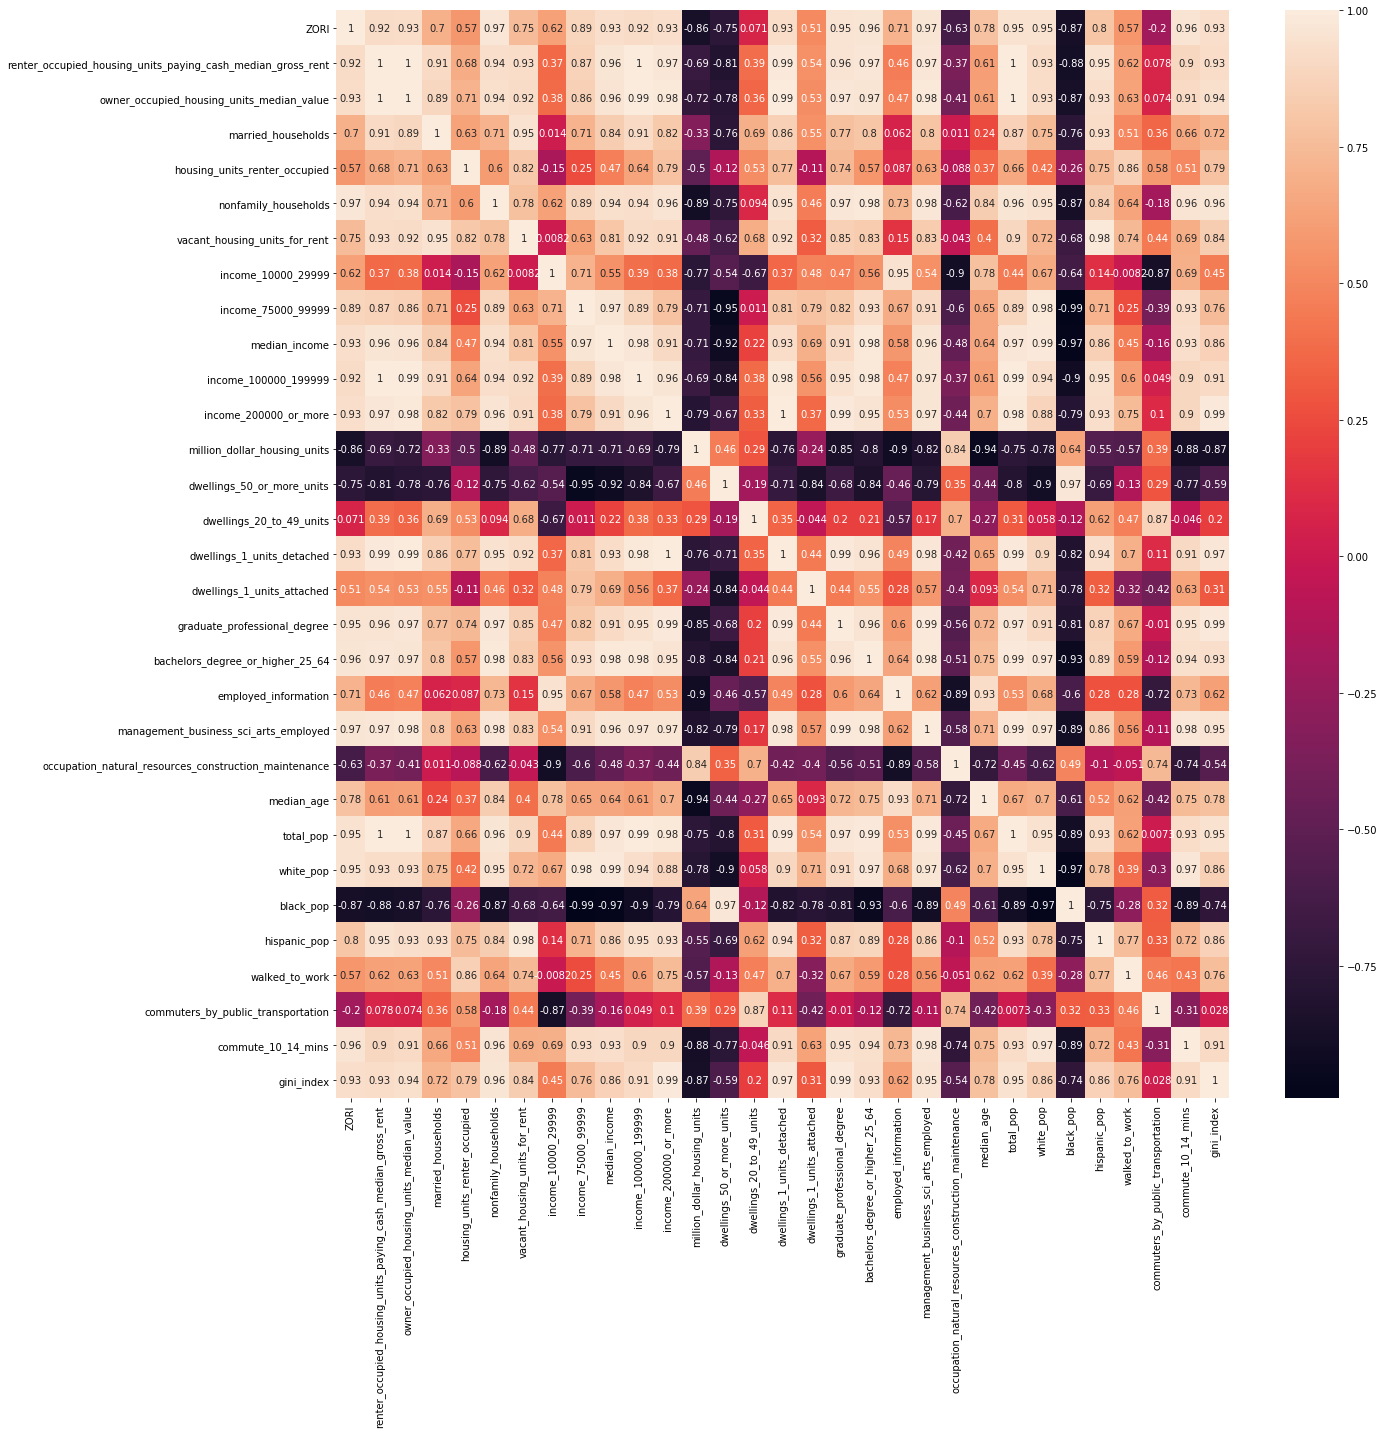

In [6]:
corr = df2.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True)